# Tutorial to the use of `cdg` 

[Daniele Zambon](https://dzambon.github.io) (`daniele.zambon@usi.ch`)  
_Università della Svizzera italiana_     
Last Update: 16/09/2019   

## Install the package

You can get it from [GitHub](https://github.com/dzambon/cdg).

In [1]:
import cdg
print("notebook prepared with cdg version:", cdg.__version__)

notebook prepared with cdg version: 2.1


## Demo

In [5]:
# Generate synthetic graphs from a predefined model
#   - 500 graphs from class 0
#   - 50 graphs from class 8
from cdg.graph import DelaunayGraphs, convert
no_nodes = 5
no_graphs = {0: 500, 8: 50}
model = DelaunayGraphs()
G = model.get(seed_points=no_nodes, classes=list(no_graphs.keys()),
              no_graphs=no_graphs, sigma=.3, include_seed_graph=False)

print(G)

OrderedDict([(0, [<cdg.graph.graph.Graph object at 0x7f69b37ac9d0>, <cdg.graph.graph.Graph object at 0x7f69b359bca0>, <cdg.graph.graph.Graph object at 0x7f69b2da8df0>, <cdg.graph.graph.Graph object at 0x7f69b2da85e0>, <cdg.graph.graph.Graph object at 0x7f69b2da88e0>, <cdg.graph.graph.Graph object at 0x7f69b2da8160>, <cdg.graph.graph.Graph object at 0x7f69b2da8c10>, <cdg.graph.graph.Graph object at 0x7f69b2da8550>, <cdg.graph.graph.Graph object at 0x7f69b2db9f10>, <cdg.graph.graph.Graph object at 0x7f69b2db9f40>, <cdg.graph.graph.Graph object at 0x7f69b2db7e80>, <cdg.graph.graph.Graph object at 0x7f69b2db7d90>, <cdg.graph.graph.Graph object at 0x7f69b2db7d00>, <cdg.graph.graph.Graph object at 0x7f69b2db7730>, <cdg.graph.graph.Graph object at 0x7f69b2db7a60>, <cdg.graph.graph.Graph object at 0x7f69b2db70d0>, <cdg.graph.graph.Graph object at 0x7f69b2db7340>, <cdg.graph.graph.Graph object at 0x7f69b2db72e0>, <cdg.graph.graph.Graph object at 0x7f69b2db7ca0>, <cdg.graph.graph.Graph object at

In [6]:
# Generate synthetic graphs from a predefined model
#   - 500 graphs from class 0
#   - 50 graphs from class 8
from cdg.graph import DelaunayGraphs, convert
no_nodes = 5
no_graphs = {0: 500, 8: 50}
model = DelaunayGraphs()
G = model.get(seed_points=no_nodes, classes=list(no_graphs.keys()),
              no_graphs=no_graphs, sigma=.3, include_seed_graph=False)

# Convert them
from cdg.graph.distance import GraphEditDistanceNX
ged = GraphEditDistanceNX(node_cost='euclidean', n_jobs=2)
Gnx = convert(G[0] + G[8], format_in='cdg', format_out='nx')
G_train, G_test = Gnx[:50], Gnx[50:]

from cdg.embedding import MultiDimensionalScaling
mds = MultiDimensionalScaling(emb_dim=2, nprot=5)
mds.fit(graphs=G_train, dist_fun=ged.get_measure_fun(verbose=True))
x = mds.transform(G_test)

from cdg.changedetection import GaussianCusum
cdt = GaussianCusum(window_size=5, arl=20)
cdt.fit(x[:100])
y, g = cdt.predict(x, reset=False)


ModuleNotFoundError: No module named 'grakel'

In [3]:
import matplotlib.pyplot as plt
plt.plot(g, 'b', label="cumulative sum")
plt.plot(g*0. + cdt.threshold, '--k', label="threshold")
plt.plot([450]*2, [g.min(), g.max()], '--r', label="change")
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

## Change detection 

Let's generate a sample sequence with a change simulated at time `N_change`

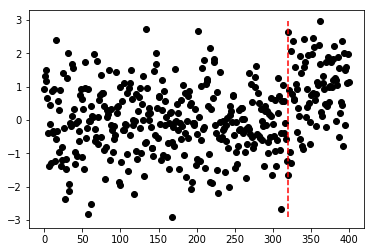

In [4]:
import numpy as np
N = 400
N_train = 100
N_change = 320
alpha = 0.01

x = np.random.normal(size=(N, 1))
x[N_change:] += 1.

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(np.arange(N), x, c='k', label="x(t)")
plt.plot([N_change]*2, [x.min(), x.max()], '--r', label="N_change")
plt.show()

### Change-detection test

Under the assumption that the process is Gaussian and i.i.d. one can use `GaussianCusum`.


In [5]:
from cdg.changedetection import GaussianCusum
cdt = GaussianCusum(arl=round(1./alpha))
cdt.fit(x[:N_train])
y, g = cdt.predict(x, reset=False)

One could also proceed iterative time-step by time-step

In [6]:
cdt.reset()
cdt.fit(x[:N_train])
for t in range(N):
    alarm, _ = cdt.iterate(x[t:t + 1])
    if alarm:
        print("An alarm is raised at time {}".format(t))
        cdt.reset()

An alarm is raised at time 33
An alarm is raised at time 326
An alarm is raised at time 354
An alarm is raised at time 361
An alarm is raised at time 398


One the above assumption is not appropriate, one can:

* use a windowing approach with `GaussianCusum(window_size=50)` that exploits the central limit theorem;
* use the nonparametric `TwoSidedCusum`.


### Change-point method


In [7]:
from cdg.changedetection import MuCPM
cpm = MuCPM()
cpm.predict(x, alpha=alpha, margin=20)
print("Identified change-point:", cpm.cps_fwer, 'with p-value:', cpm.pvals_fwer)

Identified change-point: [320] with p-value: [4.4086956307864966e-13]


## Data sets

### Load a data set


In [8]:
from cdg.graph import DataSet, isdataset
path = './dataset/delaunay'
if isdataset(path):
    dataset = DataSet.load_dataset(path=path, name='MyDataSet')   
else:
    print('Data set not there...')

Data set not there...



### Generate Delaunay's triangulation graphs

In [9]:
from cdg.graph import DelaunayGraphs 
no_nodes = 7
no_graphs = 100
model = DelaunayGraphs()
G = model.get(seed_points=no_nodes, classes=[0, 8], 
              no_graphs=no_graphs, sigma=.3, include_seed_graph=False) 
print(G[0][0])

cdg.Graph[no_nodes: 7, nf_dim: 2, ef_dim: 0](
---Adjacency---
[[0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0. 1.]
 [1. 1. 0. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 0.]]
---NodeFeatures---
[[8.84106585 2.46721861]
 [1.1429479  5.13683779]
 [7.65771102 2.30314049]
 [1.99294489 1.42906562]
 [6.69154097 9.50241862]
 [7.91662357 1.26672989]
 [7.99898016 3.16394143]])



### Generate graphs from the stochastic block model

In [10]:
from cdg.graph import StochasticBlockModel 
no_nodes = 7
no_graphs = 100
model = StochasticBlockModel(
            communities=[list(range(no_nodes//2)), list(range(no_nodes//2, no_nodes))],
            prob_matrix=[[.8, .2], [.2, .6]])

G = model.get(no_graphs)
print(G[0])

cdg.Graph[no_nodes: 7, nf_dim: 0, ef_dim: 0](
---Adjacency---
[[0 0 0 0 0 1 0]
 [0 0 1 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 1]
 [0 1 0 0 0 0 0]
 [1 0 0 1 0 0 1]
 [0 0 0 1 0 1 0]])



### Generate graphs from the degree-corrected stochastic block model

In [11]:
from cdg.graph import DegreeCorrectedStochasticBlockModel
no_nodes = 7
no_graphs = 100
model = DegreeCorrectedStochasticBlockModel(
    communities=[list(range(no_nodes // 2)), list(range(no_nodes // 2, no_nodes))],
    prob_matrix=[[.8, .2], [.2, .6]],
    delta=[0.1, 0.02])

G = model.get(no_graphs)
print(G[0])

cdg.Graph[no_nodes: 7, nf_dim: 0, ef_dim: 1](
---Adjacency---
[[1 1 0 0 0 0 1]
 [1 1 1 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 0 1 0 0 1]
 [0 0 0 0 1 1 1]
 [0 0 0 0 1 1 0]
 [1 0 0 1 1 0 1]]
---EdgeFeatures---
[[1 2 0 0 0 0 1]
 [2 1 1 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 0 1 0 0 1]
 [0 0 0 0 1 1 1]
 [0 0 0 0 1 1 0]
 [1 0 0 1 1 0 1]])


### Store a data set

In [12]:
# The path needs to be present
path = './data/my-del'
# Create graphs
no_nodes = 7
no_graphs = 100
model = DelaunayGraphs()
G = model.get(seed_points=no_nodes, classes=[0, 8], 
              no_graphs=no_graphs, sigma=.3, include_seed_graph=False) 
labels = np.array([0] * no_graphs + [8] * no_graphs)
# Create data set and store it
dataset = DataSet(graphs=G[0]+G[8], labels=labels, name='my-delaunay', store=path)

print("Is data set there?", isdataset(path))

Is data set there? True



### Dynamic model

In [13]:
from cdg.graph import StochasticBlockModel, DynamicsGenerator
no_nodes = 8
no_graphs = 100
alpha = .5

base_model = StochasticBlockModel(communities=[list(range(no_nodes))], prob_matrix=[[.3]])
#getter = lambda : base_model.get(no_graphs=1)[0]
#dyn_model = DynamicsGenerator(alpha=alpha, getter=getter)
#G = dyn_model.get(no_graphs=no_graphs)


## Simulations

### Run a simulation of CPM
Collect a data set


In [14]:
from cdg.graph import StochasticBlockModel, DataSet, FrobeniusGraphDistance
# Generate graphs
no_nodes = 7
no_graphs_class_0, no_graphs_class_1 = 100, 50
model0 = StochasticBlockModel(communities=[list(range(no_nodes))],
                              prob_matrix=[[.2]])
model1 = StochasticBlockModel(communities=[list(range(no_nodes))],
                              prob_matrix=[[.3]])
graphs  = model0.get(no_graphs=no_graphs_class_0)
graphs += model1.get(no_graphs=no_graphs_class_1)
y = [0] * no_graphs_class_0 + [1] * no_graphs_class_1
# Choose a distance
frob_distance = FrobeniusGraphDistance().get_measure_fun()
# Create an instance of cdg.DataSet
dataset = DataSet(graphs=graphs, labels=y, name='SBM_example',
                  distance_measure=frob_distance,
                  store=None, class_to_label=None, kernel_measure=None)

# Setup the simulation
from cdg import SimulationCPM, ParametersCPM
from cdg.changedetection import EnergyCPM
from cdg.embedding import MultiDimensionalScaling
# define the parameters of the simution
pars = ParametersCPM()
pars.classes = [0, 1]
pars.subseq_lengths_t = [no_graphs_class_0, no_graphs_class_1]
pars.significance_level = 0.01
pars.embedding_dimension = 3
# instance of an embedding class extending cdg.Embedding
pars.embedding_method = MultiDimensionalScaling(emb_dim=pars.embedding_dimension)
# freeze the parameters to make sure that nothing will change from now on.
pars.freeze()
# crate instance of a CPM
cpm = EnergyCPM(repetitions=499)
# crate the environment for assessing the performance of a CPM.
simulation = SimulationCPM(cpm=cpm)
simulation.set(parameters=pars, dataset=dataset, no_simulations=10, folder='./my_experiment')
simulation.run()

prot. sel. annealing: 100%|██████████| 3/3 [00:00<00:00, 336.12it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
prot. sel. annealing: 100%|██████████| 3/3 [00:00<00:00, 343.82it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
prot. sel. annealing: 100%|██████████| 3/3 [00:00<00:00, 378.78it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
prot. sel. annealing: 100%|██████████| 3/3 [00:00<00:00, 250.84it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
prot. sel. annealing: 100%|██████████| 3/3 [00:00<00:00, 456.90it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBacke